##### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import glob 
from sklearn.model_selection import train_test_split

##### Load the dataset

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def construct_img(arr):
    return np.stack(np.split(arr, 3), axis=-1).reshape((32, 32, 3))
    
def unflatten_data(data):
    images = []
    for item in list(data):
        images.append(construct_img(item))
    return np.stack(images, axis=0)

In [3]:
data_batches = glob.glob('cifar-10-batches-py/data_batch_*')
data, labels = [], []

for batch in data_batches:
    data.append(unpickle(batch)[b'data'])
    labels.append(unpickle(batch)[b'labels'])

X_full_flattened = np.concatenate(data, axis=0)
X_full = unflatten_data(X_full_flattened)
y_full = np.concatenate(labels, axis=0)
X_test_flattened = unpickle('cifar-10-batches-py/test_batch')[b'data']
X_test = unflatten_data(X_test_flattened)
y_test = np.array(unpickle('cifar-10-batches-py/test_batch')[b'labels'])

X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, train_size=0.7, random_state=42)

In [4]:
### Scale pixel values
X_train = X_train / 255
X_valid = X_valid / 255
X_test = X_test / 255

##### Display sample images

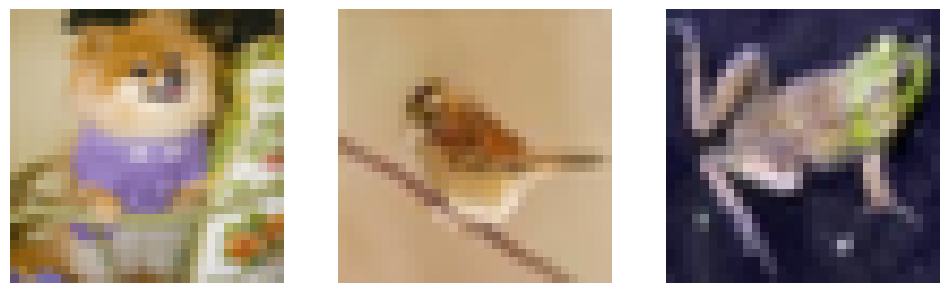

In [5]:
img_0 = X_train[45]
img_1 = X_train[3]
img_2 = X_train[267]

fig, ax = plt.subplots(1, 3, figsize=(12, 12))
ax[0].imshow(img_0)
ax[1].imshow(img_1)
ax[2].imshow(img_2)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

##### Build the model

In [7]:
from keras.layers import Input, Dense, Lambda, Flatten, Conv2D, MaxPooling2D, Dropout
from keras import Model
from keras import regularizers

img_dim = (32, 32, 3)
kernel_size = (3, 3)
pool_size = (2, 2)

input_ = Input(shape=X_train.shape[1:])
conv2d_1 = Conv2D(filters=32, kernel_size=kernel_size, activation='relu')(input_)
pooling_1 = MaxPooling2D(pool_size=pool_size)(conv2d_1)
conv2d_2 = Conv2D(filters=64, kernel_size=kernel_size, activation='relu')(pooling_1)
pooling_2 = MaxPooling2D(pool_size=pool_size)(conv2d_2)
conv2d_3 = Conv2D(filters=128, kernel_size=kernel_size, activation='relu')(pooling_2)
pooling_3 = MaxPooling2D(pool_size=pool_size)(conv2d_3)
flatten = Flatten()(pooling_2)
dense_1 = Dense(400, activation='relu', kernel_regularizer=regularizers.L2(2e-2))(flatten)
dense_2 = Dense(200, activation='relu', kernel_regularizer=regularizers.L2(1e-2))(dense_1)
output = Dense(10, activation='softmax')(dense_2)
model = Model(inputs=[input_], outputs=[output])

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2304)              0     

In [9]:
from keras.optimizers import SGD

model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(learning_rate=0.05), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1094/1094 [==============================] - 12s 10ms/step - loss: 6.1256 - accuracy: 0.3103 - val_loss: 2.1726 - val_accuracy: 0.4243
Epoch 2/30
1094/1094 [==============================] - 11s 10ms/step - loss: 1.8340 - accuracy: 0.4404 - val_loss: 1.7110 - val_accuracy: 0.4369
Epoch 3/30
1094/1094 [==============================] - 12s 11ms/step - loss: 1.6091 - accuracy: 0.4788 - val_loss: 1.5562 - val_accuracy: 0.4859
Epoch 4/30
1094/1094 [==============================] - 12s 11ms/step - loss: 1.5280 - accuracy: 0.5157 - val_loss: 1.5164 - val_accuracy: 0.5326
Epoch 5/30
1094/1094 [==============================] - 12s 11ms/step - loss: 1.4728 - accuracy: 0.5444 - val_loss: 1.4727 - val_accuracy: 0.5489
Epoch 6/30
1094/1094 [==============================] - 12s 11ms/step - loss: 1.4341 - accuracy: 0.5670 - val_loss: 1.5661 - val_accuracy: 0.5125
Epoch 7/30
1094/1094 [==============================] - 12s 11ms/step - loss: 1.4110 - accuracy: 0.5808 - val_loss: 1.4373 -

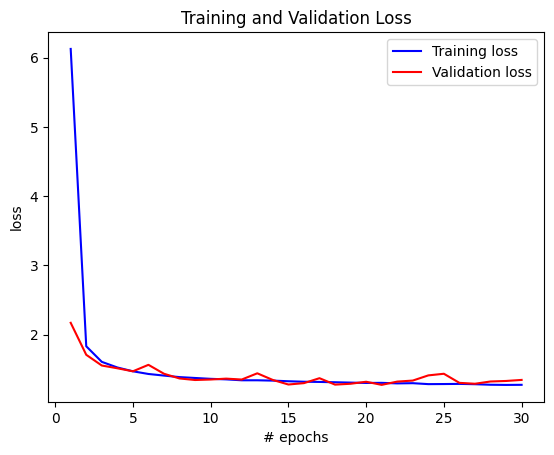

In [10]:
epochs = range(1, len(history.history["loss"])+1)
plt.plot(epochs, history.history["loss"], "b", label="Training loss")
plt.plot(epochs, history.history["val_loss"], "r", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("# epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

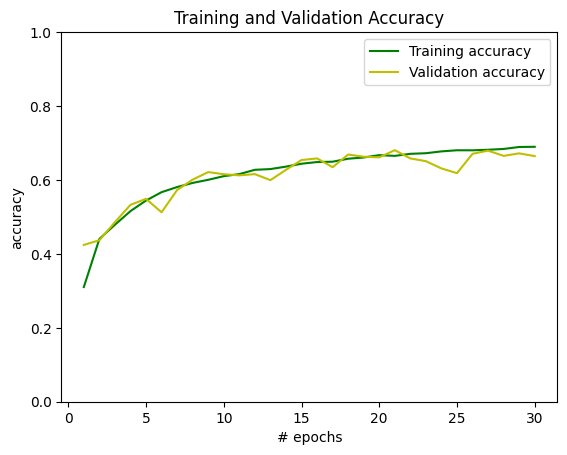

In [11]:
epochs = range(1, len(history.history["accuracy"])+1)
plt.plot(epochs, history.history["accuracy"], "g", label="Training accuracy")
plt.plot(epochs, history.history["val_accuracy"], "y", label="Validation accuracy")
plt.ylim(0, 1)
plt.title("Training and Validation Accuracy")
plt.xlabel("# epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

##### Evaluate the model

In [40]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.3666 - accuracy: 0.6644


[1.3666303157806396, 0.6643999814987183]

313/313 [==============================] - 1s 3ms/step


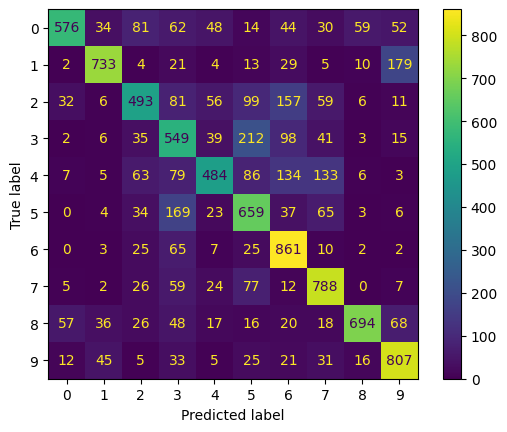

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_probabilities = model.predict(X_test)
predictions = np.argmax(predicted_probabilities, axis=1)
conf_mat = confusion_matrix(y_test, predictions)
conf_mat_display = ConfusionMatrixDisplay(conf_mat)
conf_mat_display.plot()
plt.show()